Wavelet Transform
https://www.youtube.com/watch?v=spUNpyF58BY&t=423s
https://pywavelets.readthedocs.io/en/latest/install.html


In [24]:
import numpy as np
import pywt
import cv2 as cv
import matplotlib.pyplot as plt
import os


In [25]:
def w2d(img,mode ="haar",level = 1):
    #Convert the cropped faces in grayscale from cleaned data to float representations 
    image = np.float32(img)
    image/=255
    
    #Compute coefficients
    coefficients = pywt.wavedec2(image,mode,level=level)

    #Processing the coefficients
    haar_coeff = list(coefficients)
    #Removing the contribution of the lowest frequency . The first coefficient gives the average grey value of the image
    haar_coeff[0] *= 0 

    #Reconstruct the image from the coefficients
    wavelet_image = pywt.waverec2(haar_coeff,mode)
    #Scaling with the max gray value
    wavelet_image*=255
    wavelet_image = np.uint8(wavelet_image)

    return wavelet_image


In [ ]:
#Wavelet Transform Example with 1 image
image_path = "D:\Study\Projects\ImageClassification\PremierLeaguePlayersClassifier\Images\Son\cropped\image47.png"
raw_image = cv.imread(image_path)
image_features = w2d(raw_image,'db1',5)
#print(image_features)
#plt.imshow(raw_image,cmap='gray')
plt.imshow(image_features)

Creating X and Y of the dataset to train the model with the cropped images and their respective labels

In [26]:

footballers_dict = {}
footballers_images_dict = {}
count = 0
for entry in os.scandir("./Images"):
    player_name = entry.name
    training_image_path = os.scandir(entry.path+"./cropped")
    footballers_dict[player_name] = count
    training_images = []
    for image in training_image_path:
        #print(image)
        training_images.append(image)
    footballers_images_dict[player_name] = training_images
    #print(player_name,footballers_images_dict[player_name])
    count+=1


In [27]:
X, y =[],[]

for player in footballers_images_dict.keys():
    count=1
    for image in footballers_images_dict[player]:
        raw_image = cv.imread(image)
        scaled_raw_image = cv.resize(raw_image,(32,32))
        haar_image = w2d(raw_image,'db1',5)
        scaled_haar_image = cv.resize(haar_image,(32,32))
        #Converting to Gray scale to get a shape of (32,32,1)
        scaled_haar_image = cv.cvtColor(scaled_haar_image,cv.COLOR_BGR2GRAY)
        #print("raw_image shape ",scaled_raw_image.shape)
        #print("haar_image shape",scaled_haar_image.shape)
        combined_image = np.vstack((scaled_raw_image.reshape(32*32*3,1),scaled_haar_image.reshape(32*32*1,1)))
        X.append(combined_image)
        y.append(footballers_dict[player])
       

d:\Software\Python\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [42]:
#Lets take the time to understand the dimensions
print(len(X))
print(len(X[0]))
print(y)

170
4096
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [28]:
# X - X is a list of array having 4096 number of values (32*32*3) +(32*32*1)  in each element representative of each cropped training image.
# Now lets convert this list into an Numpy 2D array of (len(X),4096) dimensions. we have len(X) entries (different images) and 
# for each of these len(X entries we have corresponding label in y.
#Converting to float to use it in sklearn smoothly

X = np.array(X).reshape(len(X),len(X[0])).astype(float)
X.shape


(170, 4096)

Model Training

In [29]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7209302325581395

In [31]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        12
           1       0.67      0.50      0.57         8
           2       0.71      0.42      0.53        12
           3       0.77      0.91      0.83        11

    accuracy                           0.72        43
   macro avg       0.71      0.71      0.69        43
weighted avg       0.72      0.72      0.70        43



In [32]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [33]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [34]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False) #5 fold cross validation
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

d:\Software\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\Software\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\Software\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\Software\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be remove

,model,best_score,best_params
0,svm,0.833538,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.787692,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.849231,{'logisticregression__C': 1}


In [35]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [36]:
print("The score for SVM on test data",  best_estimators['svm'].score(X_test,y_test))
print("The score for Random Forest on test data",  best_estimators['random_forest'].score(X_test,y_test))
print("The score for Logistic Regression on test data",  best_estimators['logistic_regression'].score(X_test,y_test))
best_model = best_estimators['svm']

The score for SVM on test data 0.8372093023255814
The score for Random Forest on test data 0.6976744186046512
The score for Logistic Regression on test data 0.813953488372093


In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
cm

array([[12,  0,  0,  0],
       [ 1,  5,  2,  0],
       [ 2,  0,  8,  2],
       [ 0,  0,  0, 11]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

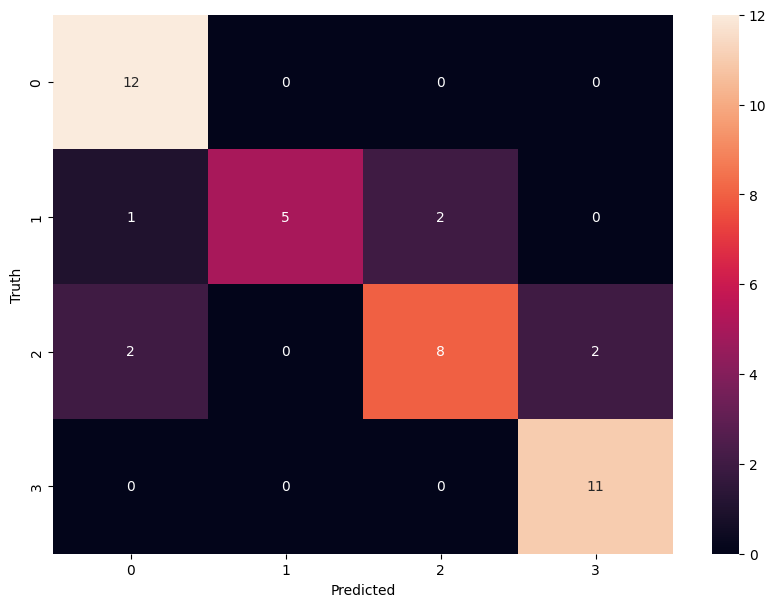

In [38]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [39]:
# Save the trained Model as a pickel model
import joblib
# Save the model as a pickle in a file 
joblib.dump(best_model, 'saved_model.pkl') 

['saved_model.pkl']

In [41]:
#Save the labels as json file
import json
with open("players_dictionary.json","w") as f:
    f.write(json.dumps(footballers_dict))